In [1]:
import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [2]:
raw = pd.read_csv('Scorecard_Final.csv', low_memory=False)
#source https://www.kaggle.com/kaggle/college-scorecard/home
#each row in this dataset is a branch of a higher education institution. The data comes from the US Dept of Education Scorecard 
#and has been filtered down such that my machine can import it

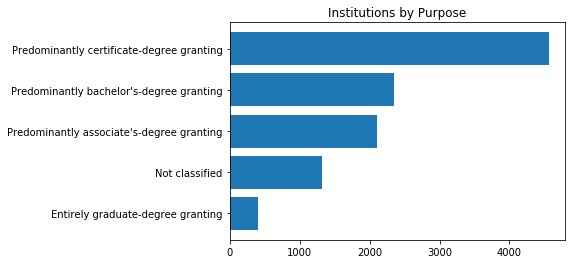

In [3]:
#This cell groups and sums unique institutions (not branches) by their Predominant Degree
predDegree = raw.groupby('PREDDEG')['UNITID'].nunique().sort_values(ascending=True)
plt.barh(predDegree.keys(),predDegree.values)
plt.title('Institutions by Purpose')
plt.show()

Total Institutions in population: 9091
CONTROL             relig    
Private for-profit  Secular      4655
Public              Secular      2285
Private nonprofit   Secular      2258
                    Religious     917
Name: UNITID, dtype: int64


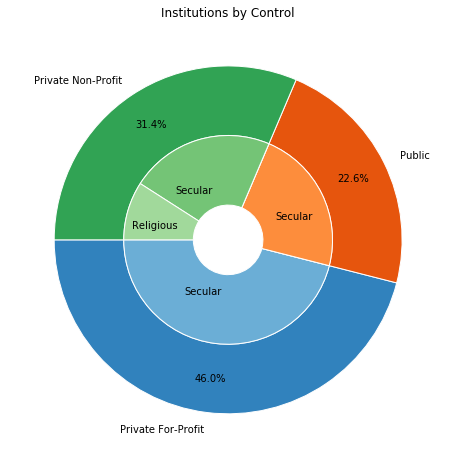

In [4]:
#How many of these institutions are there?
print("Total Institutions in population: " + str(raw['UNITID'].nunique()))

#How many are under private vs public control, and how many are religious?

#Create a column that consolidates the various Religious affiliations into a single "Religious" bucket:
raw['relig'] = np.where(raw['RELAFFIL'] == 'None', 'Secular', 'Religious')


#What values should be passed into the donut graph? By printing the below statement, I got a table with the data I want to graph.
control = raw.groupby(['CONTROL', 'relig'])['UNITID'].nunique()
print(control.sort_values(ascending=False))


##DONUT CHART TO SHOW THE BREAKDOWN


#These vals come from the control table printed above. I couldn't figure out how to pass them directly in, since 
#2/3 groups don't have any religious value at all, so there's nothing to pass without manually suggesting a zero value.
#it seemed much simpler to just retype them ... it's only 6 numbers.
vals = np.array([[4655,0], [2285,0], [2258,917]])

fig, ax = plt.subplots(figsize=(8, 8))
size = 0.4
stan = 180 #tweak this starting angle as needed to get the labels looking good, in addition to labeldistance below in the .pie call

#set colors such that the parent and child groups will appear similar:
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))


ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=['Private For-Profit', 'Public', 'Private Non-Profit'], startangle=stan, autopct='%1.1f%%', pctdistance=.8)

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=['Secular', '', 'Secular', '', 'Secular', 'Religious'], labeldistance=0.5, rotatelabels=False, startangle=stan)

ax.set(aspect="equal", title='Institutions by Control')
plt.show()


In [5]:
#To analyze the most recent net prices, I'm going to isolate the 2013 data:
yr13Raw = raw[raw.Year == 2013]

#For some reason, public prices and private prices were put in separate columns, despite being mutually exclusive categories.
#I'm replacing NaN's with float zeros to enable accurate addition, then I'll sum them into a single column for Net Price.
yr13Net = yr13Raw.fillna({'NPT4_PUB':0.0, 'NPT4_PRIV':0.0})

yr13Net = yr13Net.assign(netPrice=yr13Net.NPT4_PUB + yr13Net.NPT4_PRIV)

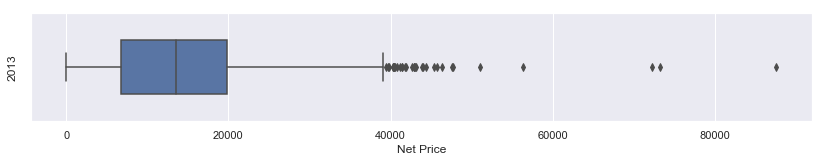

In [6]:
#There's a few negative values, which I'm going to replace with zero
#I considered removing these entirely, but net price is the cost less average scholarships. I suppose it's possible that 
#a few universities break even on undergraduate activites and make their money other ways, so I'm leaving them in.
yr13Net.loc[yr13Net.netPrice < 0, 'netPrice'] = 0


sns.set(style="darkgrid")
plt.figure(figsize=(14,2))
ax = sns.boxplot(x='netPrice', data=yr13Net, width=.5)
plt.xlabel('Net Price')
plt.ylabel(2013)
plt.show()

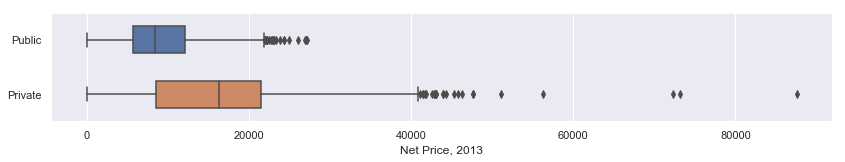

In [7]:
#Create a contr column that consolidates all types of private branches into a single private bucket.
yr13Net['contr'] = np.where(yr13Net.CONTROL == 'Public', 'Public', 'Private')

sns.set(style="darkgrid")
plt.figure(figsize=(14,2))
ax = sns.boxplot(y='contr', x='netPrice', data=yr13Net, width=.5)
plt.xlabel('Net Price, 2013')
plt.ylabel('')
plt.show()

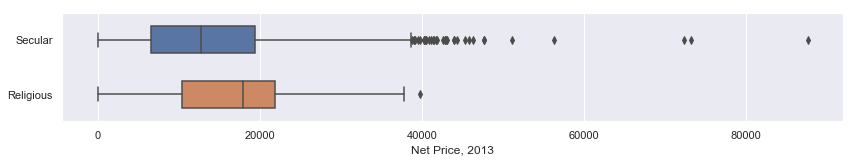

In [8]:
sns.set(style="darkgrid")
plt.figure(figsize=(14,2))
ax = sns.boxplot(y='relig', x='netPrice', data=yr13Net, width=.5)
plt.xlabel('Net Price, 2013')
plt.ylabel('')
plt.show()

In [9]:
#DEBT

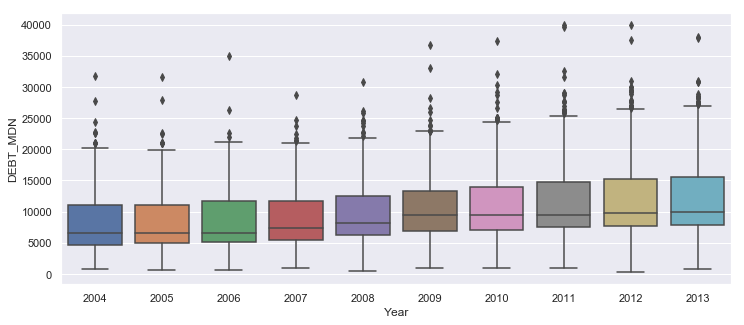

In [10]:
#To analyze debt, I want to create a df with only the rows that have values for the 
#median debt upon the start of repayment
debt = raw[(np.isnan(raw.DEBT_MDN) == False) & (np.isnan(raw.DEBT_N) == False)]

#range of debt values by year
sns.set(style="darkgrid")
plt.figure(figsize=(12,5))
ax = sns.boxplot(y='DEBT_MDN', x='Year', data=debt)

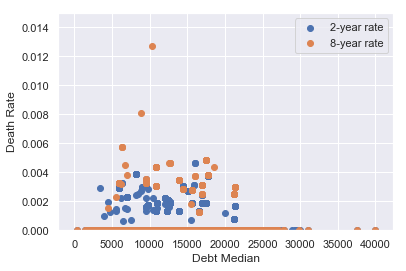

In [11]:
#Do the median debt values recorded in 2012 correlate with death rate?

#Create a table for the most recent year with reported death rates, 2012
debt12Death = debt[(debt.Year == 2012) & (np.isnan(debt.DEATH_YR2_RT) == False)]


plt.scatter(debt12Death.DEBT_MDN,debt12Death.DEATH_YR2_RT, label="2-year rate")
plt.scatter(debt12Death.DEBT_MDN,debt12Death.DEATH_YR8_RT, label='8-year rate')
plt.ylim(0,0.015)
plt.xlabel('Debt Median')
plt.ylabel('Death Rate')
plt.legend()
plt.show()


#Death as recorded within 2 and 8 years:

In [12]:
#Early data review determined that the count of students (DEBT_N) for the debt measurements was innaccurate. Many
# Schools with numerous branches seem to report the same number for all branches, suggesting they might have mistakenly
#listed the institution total for EVERY branch. Here I divide the count by the branch count to estimate a true student count
#for the branch.
debt = debt.assign(studNum = debt['DEBT_N'] / debt['NUMBRANCH'])


#This is an estimate of the total debt issued to students on behalf of each branch
debt = debt.assign(totalDebtForBranch = debt['DEBT_MDN'] * debt['studNum'])

#The rest of the these field creations are simply using the student counts of specific demographics to 
#create the % of the students who fall into each bucket.

#Data note: this could have been accomplished in an simpler way with student counts instead of using percentages. however,
#the parts didn't always sum to the whole (male_debt_n + female_debt_n != debt_n), so percents are being calculated instead.

debt['malePCT'] = debt['MALE_DEBT_N'] / (debt['MALE_DEBT_N'] + debt['FEMALE_DEBT_N'])
debt['femalePCT'] = 1 - debt['malePCT']

debt['firstGenPCT'] = debt['FIRSTGEN_DEBT_N'] / (debt['FIRSTGEN_DEBT_N'] + debt['NOTFIRSTGEN_DEBT_N'])
debt['notFirstGenPCT'] = 1 - debt['firstGenPCT']

debt['hiIncPCT'] = debt['HI_INC_DEBT_N'] / (debt['HI_INC_DEBT_N'] + debt['MD_INC_DEBT_N'] + debt['LO_INC_DEBT_N'])
debt['medIncPCT'] = debt['MD_INC_DEBT_N'] / (debt['HI_INC_DEBT_N'] + debt['MD_INC_DEBT_N'] + debt['LO_INC_DEBT_N'])
debt['lowIncPCT'] = debt['LO_INC_DEBT_N'] / (debt['HI_INC_DEBT_N'] + debt['MD_INC_DEBT_N'] + debt['LO_INC_DEBT_N'])


In [13]:
#Isolate the columns I need to improve processing speed
debtAnalysis= debt[['UNITID', 'studNum', 'totalDebtForBranch', 'malePCT', 'femalePCT', 'firstGenPCT', 'notFirstGenPCT', 'hiIncPCT', 'medIncPCT', 'lowIncPCT']]


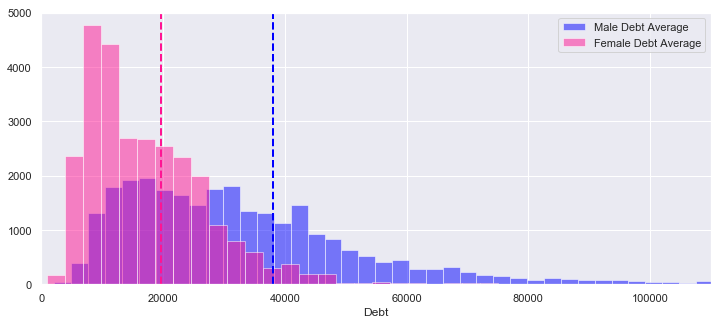

Ttest_indResult(statistic=64.28716339984733, pvalue=0.0)


In [14]:
##Sex
#BY dividing the total branch debt by the estimated number of students in each group, we can get an 
#average debt for each student.
debtAnalysis = debtAnalysis.assign(maleAvgDebt = debtAnalysis['totalDebtForBranch'] / (debt['studNum'] * debt['malePCT']))
debtAnalysis = debtAnalysis.assign(femaleAvgDebt = debtAnalysis['totalDebtForBranch'] / (debt['studNum'] * debt['femalePCT']))


#Remove Nan's
genderAnalysisInf = debtAnalysis[(np.isnan(debtAnalysis.maleAvgDebt) == False) & (np.isnan(debtAnalysis.femaleAvgDebt) == False)]
#Remove Infinite values created by the above multiplicaiton being done on blank cells
genderAnalysis = genderAnalysisInf.dropna(how='any')

plt.figure(figsize=(12,5))
plt.hist(genderAnalysis['maleAvgDebt'], bins=400, label='Male Debt Average', alpha=.5, color='#0000FF')
plt.axvline(genderAnalysis.maleAvgDebt.mean(), color='#0000FF', linestyle='dashed', linewidth=2)
plt.hist(genderAnalysis['femaleAvgDebt'], bins=200, label='Female Debt Average', alpha=.5, color='#FF1493')
plt.axvline(genderAnalysis.femaleAvgDebt.mean(), color='#FF1493', linestyle='dashed', linewidth=2)
plt.xlim(0,110000)
#plt.ylabel('Branches')
plt.xlabel('Debt')
plt.legend()
plt.show()

print(ttest_ind(genderAnalysis.maleAvgDebt, genderAnalysis.femaleAvgDebt, equal_var=False))

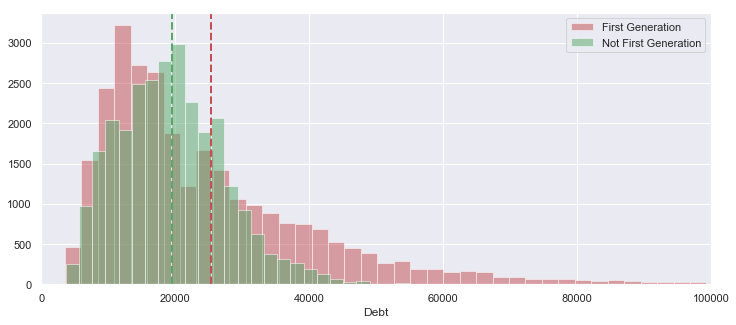

Ttest_indResult(statistic=48.29341266353475, pvalue=0.0)


In [15]:
##First Generation
#BY dividing the total branch debt by the estimated number of students in each group, we can get an 
#average debt for each student.
debtAnalysis['firstGenAvgDebt'] = debtAnalysis['totalDebtForBranch'] / (debt['studNum'] * debt['firstGenPCT'])
debtAnalysis['notFirstGenAvgDebt'] = debtAnalysis['totalDebtForBranch'] / (debt['studNum'] * debt['notFirstGenPCT'])

#Remove NaN's
generationAnalysisInf = debtAnalysis[(np.isnan(debtAnalysis.firstGenAvgDebt) == False) & (np.isnan(debtAnalysis.firstGenAvgDebt) == False)]
#Remove Infinite values created by the above multiplication being done on blank cells
generationAnalysis = generationAnalysisInf.dropna(how='any')

plt.figure(figsize=(12,5))
plt.hist(generationAnalysis['firstGenAvgDebt'], bins=100, label='First Generation', alpha=.5, color='r', density=False)
plt.hist(generationAnalysis['notFirstGenAvgDebt'], bins=40, label='Not First Generation', alpha=.5, color='g', density=False)
plt.axvline(generationAnalysis.firstGenAvgDebt.mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(generationAnalysis.notFirstGenAvgDebt.mean(), color='g', linestyle='dashed', linewidth=2)
plt.xlim(0,100000)
plt.xlabel('Debt')
plt.legend()
plt.show()

print(ttest_ind(generationAnalysis.firstGenAvgDebt, generationAnalysis.notFirstGenAvgDebt, equal_var=False))

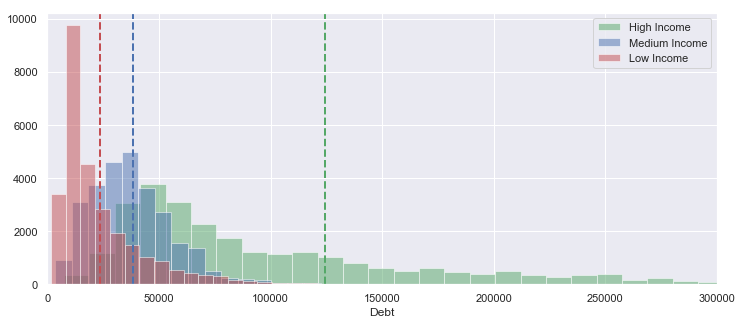

Ttest_indResult(statistic=98.43556257606531, pvalue=0.0)
Ttest_indResult(statistic=86.51037011701736, pvalue=0.0)


In [16]:
##Income
#BY dividing the total branch debt by the estimated number of students in each group, we can get an 
#average debt for each student.
debtAnalysis['hiIncAvgDebt'] = debtAnalysis['totalDebtForBranch'] / (debt['studNum'] * debt['hiIncPCT'])
debtAnalysis['medIncAvgDebt'] = debtAnalysis['totalDebtForBranch'] / (debt['studNum'] * debt['medIncPCT'])
debtAnalysis['lowIncAvgDebt'] = debtAnalysis['totalDebtForBranch'] / (debt['studNum'] * debt['lowIncPCT'])


#Remove NaN's
incomeAnalysisInf = debtAnalysis[(np.isnan(debtAnalysis.hiIncAvgDebt) == False) & (np.isnan(debtAnalysis.medIncAvgDebt) == False)  & (np.isnan(debtAnalysis.lowIncAvgDebt) == False)]
#Remove Infinite values created by the above multiplication being done on blank cells
incomeAnalysis = incomeAnalysisInf.dropna(how='any')

plt.figure(figsize=(12,5))
plt.hist(incomeAnalysis['hiIncAvgDebt'], bins=400, label='High Income', alpha=.5, color='g', density=False)
plt.axvline(incomeAnalysis.hiIncAvgDebt.mean(), color='g', linestyle='dashed', linewidth=2)
plt.hist(incomeAnalysis['medIncAvgDebt'], bins=30, label='Medium Income', alpha=.5, color='b', density=False)
plt.axvline(incomeAnalysis.medIncAvgDebt.mean(), color='b', linestyle='dashed', linewidth=2)
plt.hist(incomeAnalysis['lowIncAvgDebt'], bins=40, label='Low Income', alpha=.5, color='r', density=False)
plt.axvline(incomeAnalysis.lowIncAvgDebt.mean(), color='r', linestyle='dashed', linewidth=2)
plt.xlim(0,300000)
plt.xlabel('Debt')
plt.legend()
plt.show()

print(ttest_ind(incomeAnalysis.hiIncAvgDebt, incomeAnalysis.medIncAvgDebt, equal_var=False))
print(ttest_ind(incomeAnalysis.medIncAvgDebt, incomeAnalysis.lowIncAvgDebt, equal_var=False))